# Modelo de Detección de la Dislexia aplicando Machine Learning

Se va a desarrollar un modelo en Machine Learning que sea capaz de detectar si, tras contestar a 32 questiones y teniendo en cuenta el género, la lengua y la edad, una persona es disléxica o no. Cada modelo se va a entrenar y testear con dos datasets distintos: desktop.csv (Train) y tablet.csv (Test).


Para ello se va a emplear Machine Learning, importando las librerías de python. Los algoritmos que se van a implementar son:
1. K-Nearest Neighbors
2. Logistic Regression
3. Support Vector Machines
4. Random Forest
5. Tree Decision

Y finalmente, en caso de que de tiempo:

6. Neural Networks 

A contiuación, se van a importar las librerías necesarias para desarrollar el modelo de Machine Learning:
- Pandas: proporcina herramientas para el análisis de datos. Mediante esta herramienta se va leer el documento .csv donde se encuentran los datos y se van a manipular con el propósito de diseñar el modelo de Mchine Learning.
- NumPy y Matplotlib: se emplearán para el análisis y la visualización de datos. NumPy permite realizar operación y  matemáticas y manejar datos numéricos de manera eficiente y efectiva. Por otro lado, Matplotlib permite crear gráficas para visualizar los datos de manera simple y clara. 
- Seaborn: al igual que Matplotlib, se trata de una librería de visualización de datos. Sin embargo, ofrece una visualización estadística, la cua va a ser de gran utilidad para analizar la distribución de los datos.
- Warnings: gestionará las advertencias que surjan durante la ejecución del programa. En concreto se va a hacer uso de `warnings.filterwarnings('ignore')` consiguiendo ignorar las posibles advertencias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
%matplotlib inline 
warnings.filterwarnings('ignore')

A su vez, para el entrenamiento y el testeo de los distintos algoritmos de Machine Learning, se van a importar las librerías **Scikit-Learn** y para el manejo de desproporción entre casos positivos y negativos se va a importar **Imbalanced-Learn**.

In [2]:
#!pip install scikit-learn>=1.0.2 --use-feature=2020-resolver
#!pip install imblearn
#!pip install --exists-action=i scikit-learn

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import KFold
import seaborn as sns

## Modeling Preparation

Se va a comenzar leyendo los datos y exportándolos a la variable *data*, la cual va a contener la información con la que se va a construir el modelo. Mediante la librería **pandas** se va a acceder a la información, siendo capaz de:
- Comprobar si existen valores nulos
- Transformar todos los datos a valores numéricos
- Gestionar los valores nulos
- Analizar si hay variedad dentro de cada dataset

La información que se va a obtener es:

1. Genero (hombre o mujer)
2. Lengua nativa es el español
3. Lengua nativa distinta al español
4. Edad 
5. Información relacionada con las preguntas
6. Disléxico: sí o no

La información relacionada con las preguntas contiene el número de clicks que se realizan en cada ejercicio (*Clicks*), diferenciando en respuestas correctas (*Hits*) e incorrectas (*Misses*). A su vez, se cuenta con el resultado final (*Score*), que se obtiene a partir de la cantidad de aciertos por cuestión, junto con la precisión de la respuesta (*Accuracy = Hits/Clicks*) y el ratio de fallo (*Missrate = Misses/Clicks*).

Mediante estos valores se pretende predecir si una persona tiene dislexia o no.

In [3]:
data = pd.read_csv("../data/Dyt-desktop.csv", delimiter=";")
pd.set_option("display.max_columns" , None)

In [4]:
# first look train dataset
data.head()
data.iloc[:, :10].dtypes
data.shape

(3644, 197)

Se ha creado una función `prep_Data(df)`que toma como atributo de entrada un dataset y transforma los valores de las columnas *Gender, Nativelang, Otherlang y Dyslexia* en 0's o 1's, en función de su valor incial. De esta forma solo se trabajará con valores numéricos.

In [6]:
def prep_Data(ds) :
    #ds.column -> access to the column specified
    #map() -> itarates through the column specified
    ds['Gender']=ds.Gender.map({'Male': 0, 'Female': 1})
    ds['Dyslexia']=ds.Dyslexia.map({'No': 0, 'Yes': 1})
    ds['Nativelang']=ds.Nativelang.map({'No': 0, 'Yes': 1})
    ds['Otherlang']=ds.Otherlang.map({'No': 0, 'Yes': 1})

In [7]:
prep_Data(data)

Al contar con una desproporción muy elevada entre casos positivos y negativos de dislexia entre los datos se va a optar por disminuir el número de datos del dataset, mediante la librería **RandomOverSampler**, de forma que la cantidad de sies sea igual que la de noes.

In [8]:
# Class count
count_dyslexia_no, count_dyslexia_yes = data.Dyslexia.value_counts()

# Divide by class
dyslexia_no_df = data[data['Dyslexia'] == 0]
dyslexia_yes_df = data[data['Dyslexia'] == 1]

# Undersample 0-class and concat the DataFrames of both class
dyslexia_no_df = dyslexia_no_df.sample(count_dyslexia_yes)
data = pd.concat([dyslexia_no_df, dyslexia_yes_df], axis=0)

print('Random under-sampling:')
print(data.Dyslexia.value_counts())

Random under-sampling:
Dyslexia
0    392
1    392
Name: count, dtype: int64


In [9]:
print("Duplicated data from  Data Set: ",data.index.duplicated().sum())

Duplicated data from  Data Set:  0


In [9]:
data.head()

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,Clicks2,Hits2,Misses2,Score2,Accuracy2,Missrate2,Clicks3,Hits3,Misses3,Score3,Accuracy3,Missrate3,Clicks4,Hits4,Misses4,Score4,Accuracy4,Missrate4,Clicks5,Hits5,Misses5,Score5,Accuracy5,Missrate5,Clicks6,Hits6,Misses6,Score6,Accuracy6,Missrate6,Clicks7,Hits7,Misses7,Score7,Accuracy7,Missrate7,Clicks8,Hits8,Misses8,Score8,Accuracy8,Missrate8,Clicks9,Hits9,Misses9,Score9,Accuracy9,Missrate9,Clicks10,Hits10,Misses10,Score10,Accuracy10,Missrate10,Clicks11,Hits11,Misses11,Score11,Accuracy11,Missrate11,Clicks12,Hits12,Misses12,Score12,Accuracy12,Missrate12,Clicks13,Hits13,Misses13,Score13,Accuracy13,Missrate13,Clicks14,Hits14,Misses14,Score14,Accuracy14,Missrate14,Clicks15,Hits15,Misses15,Score15,Accuracy15,Missrate15,Clicks16,Hits16,Misses16,Score16,Accuracy16,Missrate16,Clicks17,Hits17,Misses17,Score17,Accuracy17,Missrate17,Clicks18,Hits18,Misses18,Score18,Accuracy18,Missrate18,Clicks19,Hits19,Misses19,Score19,Accuracy19,Missrate19,Clicks20,Hits20,Misses20,Score20,Accuracy20,Missrate20,Clicks21,Hits21,Misses21,Score21,Accuracy21,Missrate21,Clicks22,Hits22,Misses22,Score22,Accuracy22,Missrate22,Clicks23,Hits23,Misses23,Score23,Accuracy23,Missrate23,Clicks24,Hits24,Misses24,Score24,Accuracy24,Missrate24,Clicks25,Hits25,Misses25,Score25,Accuracy25,Missrate25,Clicks26,Hits26,Misses26,Score26,Accuracy26,Missrate26,Clicks27,Hits27,Misses27,Score27,Accuracy27,Missrate27,Clicks28,Hits28,Misses28,Score28,Accuracy28,Missrate28,Clicks29,Hits29,Misses29,Score29,Accuracy29,Missrate29,Clicks30,Hits30,Misses30,Score30,Accuracy30,Missrate30,Clicks31,Hits31,Misses31,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
3099,0,0,1,8,11,0,3,0,0.000000,0.272727,13,0,4,0,0.000000,0.307692,20,3,1,3,0.150000,0.050000,5,3,2,3,0.6,0.4,4,2,2,2,0.500000,0.500000,7,6,1,6,0.857143,0.142857,9,9,0,9,1.0,0.0,0,0,0,0,0.0,0.0,8,5,3,5,625.0,375.0,5,5,0,5,1.000000,0.000000,3,3,0,3,1.00,0.00,5,5,0,5,1.0,0.0,6,6,0,6,1.0,0.0,7,4,3,4,0.571429,0.428571,5,5,0,5,1.0,0.0,6,6,0,6,1.0,0.0,4,4,0,4,1.0,0.0,4,4,0,4,1.0,0.0,8,3,5,3,375.000000,625.000000,5,4,1,4,0.80,0.20,19,2,17,2,0.105263,0.894737,5,4,1,4,0.800000,0.200000,4,4,0,4,1.0,0.0,10,0,10,0,0.000000,1.000000,5,5,0,5,1.000000,0.000000,7,5,2,5,0.714286,0.285714,18,1,17,1,0.055556,0.944444,4,4,0,4,1.000000,0.000000,26,2,2,2,0.076923,0.076923,3,0,3,0,0.00,1.00,43,2,2,2,0.046512,0.046512,17,0,4,0,0.000000,0.235294,0
1385,1,0,1,7,6,6,0,6,1.000000,0.000000,6,6,0,6,1.000000,0.000000,4,4,0,4,1.000000,0.000000,7,0,7,0,0.0,1.0,5,5,0,5,1.000000,0.000000,3,3,0,3,1.000000,0.000000,3,3,0,3,1.0,0.0,0,0,0,0,0.0,0.0,2,0,2,0,0.0,1.0,6,5,1,5,0.833333,0.166667,2,2,0,2,1.00,0.00,3,3,0,3,1.0,0.0,2,2,0,2,1.0,0.0,3,3,0,3,1.000000,0.000000,2,2,0,2,1.0,0.0,2,2,0,2,1.0,0.0,1,1,0,1,1.0,0.0,0,0,0,0,0.0,0.0,4,3,1,3,0.750000,0.250000,4,0,4,0,0.00,1.00,1,0,1,0,0.000000,1.000000,2,1,1,1,0.500000,0.500000,4,2,2,2,0.5,0.5,2,1,1,1,0.500000,0.500000,2,2,0,2,1.000000,0.000000,3,2,1,2,0.666667,0.333333,9,2,0,2,0.222222,0.000000,3,1,0,1,0.333333,0.000000,10,0,3,0,0.000000,0.300000,10,0,1,0,0.00,0.10,32,0,1,0,0.000000,0.031250,21,1,1,1,0.047619,0.047619,0
2313,0,1,1,12,3,1,0,1,0.333333,0.000000,9,0,3,0,0.000000,0.333333,18,2,1,2,0.111111,0.055556,10,4,6,4,0.4,0.6,3,1,2,1,0.333333,0.666667,6,6,0,6,1.000000,0.000000,6,6,0,6,1.0,0.0,6,6,0,6,1.0,0.0,5,5,0,5,1.0,0.0,6,6,0,6,1.000000,0.000000,4,3,1,3,0.75,0.25,5,5,0,5,1.0,0.0,1,1,0,1,1.0,0.0,4,0,4,0,0.000000,1.000000,5,5,0,5,1.0,0.0,4,2,2,2,0.5,0.5,5,5,0,5,1.0,0.0,4,4,0,4,1.0,0.0,5,3,2,3,0.600000,0.400000,8,6,2,6,0.75,0.25,5,1,4,1,0.200000,0.800000,5,4,1,4,0.800000,0.200000,3,3,0,3,1.0,0.0,5,2,3,2,0.400000,0.600000,9,7,2,7,0.777778,0.222222,2,2,0,2,1.000000,0.000000,5,0,5,0,0.000000,1.000000,5,2,3,2,0.400000,0.600000,26,0,4,0,0.000000,0.153846,5,3,2,3,0.60,0.40,31,1,2,1,0.032258,0.064516,16,0,3,0,0.000000,0.187500,0
1259,1,0,0,9,3,0,1,0,0.000000,0.333333,11,1,2,1,0.090909,0.181818,15,3,0,3,0.200000

Tras transformar todos los valores del dataframe en numéricos, se va a asegurar que todos los valores sean tipo flotantes mediante la instrucción: `dataset.apply(lambda x: x.astype('float', errors='ignore'))` donde se aplica el cambio de *int* a *flot* mediante la función `astype()` dentro de una función *lambda* que recorre cada columna, accediendo a su contenido y modificándolo. 

In [10]:
data = data.apply(lambda x: x.astype('float', errors='ignore'))

Una vez se haya transformado el tipo de valor con el que se está trabajando se va a comprobar que solo contiene valores del tipo *float64*:

In [11]:
#check the data type of each column
for col in data.columns:
    if data[col].dtypes != "float64":
        print("Column {} is not a float, it is {}".format(col, data[col].dtypes))

Una vez exportados los datos se va a comporbar si hay valores nulos mediante la función `[col for col in test_df.columns if train_df[col].isnull().any()]`. 
- Mediante el bucle `for col in` se van a recorrer todas las columna y acceder a sus valores.  
- Mediante el condicional `if train_df[col].isnull().any()`se va a comprobar si alguno de los datos de la columna que se está analizando es nulo o no. 

En caso de que se encuentre un valor nulo, el atributo de salida `col` tomará el valor de dicha columna y se añadirá a una lista (función entre `[ ]`).

In [12]:
data.describe(include = [np.number])
data.isnull().values.any()
data_null_values = data.isna().sum().sum()
data_null_col = [col for col in data.columns if data[col].isnull().any()]
data_null_col

[]

### Handling outliers

Se va a prescindir de todos los valores mayores a uno en las columnas *Accuracy* y *Missrate*. Los valores mencionados representan porcentajes, por lo que no pueden superar la unidad, sin embargo, si se estudia en detalle cada variable existen valores que no cumplen este requisito dando lugar a error si no se corrige.

In [13]:
def remove_outliers_manually(df):
    print("Old Shape: ", df.shape)
    
    #Accuracy and Missrate
    for i in range(int(df.shape[1]/6)):
        col_acc_rate = df.columns[8+6*i:10+6*i]
        for j in col_acc_rate:
            df.drop(df[df[j] > 1].index, inplace=True)
    print("New Shape: ", df.shape)

In [14]:
remove_outliers_manually(data)

Old Shape:  (784, 197)
New Shape:  (490, 197)


A continuación, se va a proceder con la eliminación de los outliers, es decir, se va a prescindir de aquellos valores que se consideren anómalos. Para ello se van a emplear dos funciones *.describe()* y *sns.distplot(col)*. La primera  se utiliza para representar la distribución de los datos en un gráfico. Va a permitir visualizar la forma en que los datos están distribuidos en los datasets disponibles. A simple vista, se puede identificar como hay valores máximos que están muy alejados del percentil 75, por lo que se puede intuir que se trata de un outlier.

A su vez, la función `countplot` es útil para identificar cuantos valores positivos y negativos hay de dislexia. Se va a representar visualmente, permitiendo comparar si la muestra que se está usando es representativa de la población.

In [15]:
data.describe()

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,Clicks2,Hits2,Misses2,Score2,Accuracy2,Missrate2,Clicks3,Hits3,Misses3,Score3,Accuracy3,Missrate3,Clicks4,Hits4,Misses4,Score4,Accuracy4,Missrate4,Clicks5,Hits5,Misses5,Score5,Accuracy5,Missrate5,Clicks6,Hits6,Misses6,Score6,Accuracy6,Missrate6,Clicks7,Hits7,Misses7,Score7,Accuracy7,Missrate7,Clicks8,Hits8,Misses8,Score8,Accuracy8,Missrate8,Clicks9,Hits9,Misses9,Score9,Accuracy9,Missrate9,Clicks10,Hits10,Misses10,Score10,Accuracy10,Missrate10,Clicks11,Hits11,Misses11,Score11,Accuracy11,Missrate11,Clicks12,Hits12,Misses12,Score12,Accuracy12,Missrate12,Clicks13,Hits13,Misses13,Score13,Accuracy13,Missrate13,Clicks14,Hits14,Misses14,Score14,Accuracy14,Missrate14,Clicks15,Hits15,Misses15,Score15,Accuracy15,Missrate15,Clicks16,Hits16,Misses16,Score16,Accuracy16,Missrate16,Clicks17,Hits17,Misses17,Score17,Accuracy17,Missrate17,Clicks18,Hits18,Misses18,Score18,Accuracy18,Missrate18,Clicks19,Hits19,Misses19,Score19,Accuracy19,Missrate19,Clicks20,Hits20,Misses20,Score20,Accuracy20,Missrate20,Clicks21,Hits21,Misses21,Score21,Accuracy21,Missrate21,Clicks22,Hits22,Misses22,Score22,Accuracy22,Missrate22,Clicks23,Hits23,Misses23,Score23,Accuracy23,Missrate23,Clicks24,Hits24,Misses24,Score24,Accuracy24,Missrate24,Clicks25,Hits25,Misses25,Score25,Accuracy25,Missrate25,Clicks26,Hits26,Misses26,Score26,Accuracy26,Missrate26,Clicks27,Hits27,Misses27,Score27,Accuracy27,Missrate27,Clicks28,Hits28,Misses28,Score28,Accuracy28,Missrate28,Clicks29,Hits29,Misses29,Score29,Accuracy29,Missrate29,Clicks30,Hits30,Misses30,Score30,Accuracy30,Missrate30,Clicks31,Hits31,Misses31,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,0.469388,0.422449,0.777551,10.487755,5.426531,3.793878,0.551020,3.873469,0.6

Tras observar la distribución del *dataset* original y comprobar como sí presenta outliers, se va a proceder con el análisis y la eliminación de aquellos valores que no aporten información válida y vayan a afectar negativamente al modelo.

La función `distplot` se va a emplear para identificar la forma en que los datos están distribuidos, verificando si siguen una distribución normal o no, como afecta la presencia de outliers a la distribución y cual es la media y la desviación estándar. Es decir, se va a representar visualmente la distribución de los datos de cada variable.

La función `boxplot`representa el rango intercuartílico (IQR) de los datos. La caja (gráfico) va desde el primer cuartil (Q1) hasta el tercer cuartil (Q3), y su longitud representa el rango intercuartílico (IQR = Q3 - Q1). Los valores atípicos (outliers) son aquellos que están fuera del rango definido por 1,5 veces el IQR.

In [16]:
def plot_dist(df):
    
    rest = df.shape[1] % 4
    rows = df.shape[1]//4
    
    if rest == 0:
        rows = rows
    else:
        rows = rows + 1
        
    fig, ax = plt.subplots(ncols = 4, nrows = rows, figsize = (15, 150))
    i = 0
    ax = ax.flatten()

    for col in df.columns:
        plt.title(col)
        sns.distplot(df[col], ax=ax[i])
        i+=1
    plt.tight_layout(pad = 0.5, w_pad = 0.7, h_pad = 2.0)

In [17]:
def plot_box_whisker(df):
    
    rest = df.shape[1] % 4
    rows = df.shape[1]//4
    
    if rest == 0:
        rows = rows
    else:
        rows = rows + 1

    fig, ax = plt.subplots(ncols = 4, nrows = rows, figsize = (15, 150))
    i = 0
    ax = ax.flatten()
    
    for col in df.columns:
        plt.title(col)
        df.boxplot([col], ax=ax[i])
        i+=1
    plt.tight_layout(pad = 0.5, w_pad = 0.7, h_pad = 2.0)

Se va a trabajar solo con las variables relativas a las preguntas

In [18]:
data_Q = data.drop(columns = ['Gender','Nativelang','Otherlang','Age','Dyslexia'], axis = 1)

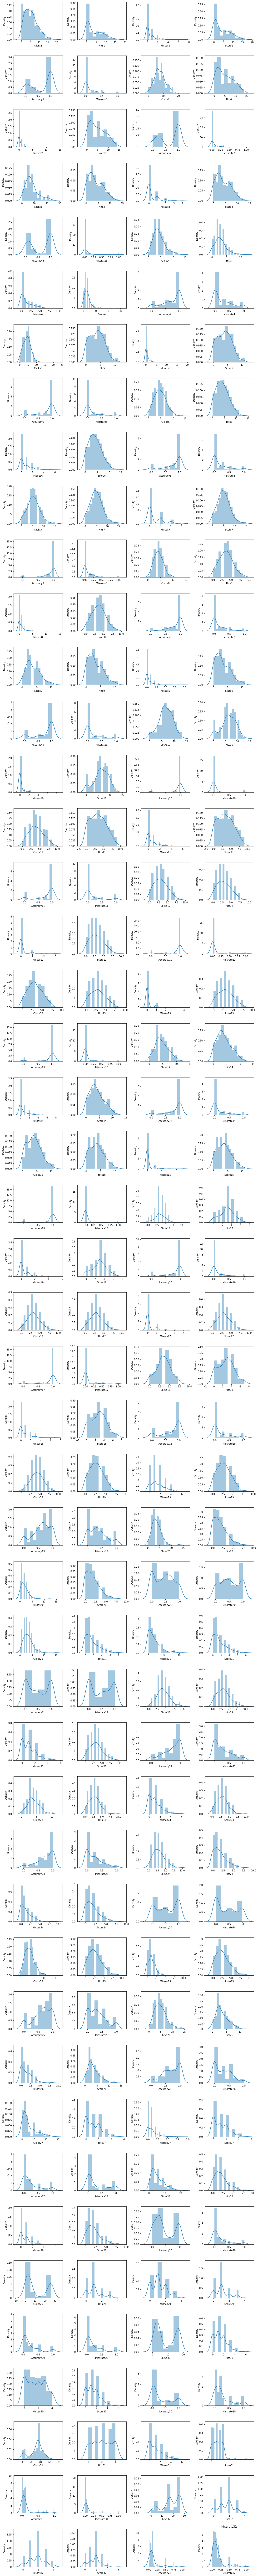

In [116]:
plot_dist(data_Q)

### Percentile method

Para la eleminación de outliers existen varias técnicas, como Z-score method, Inter Quartile Range Method o Percentile method. la técnica que se ha elegido es el método de percentil ya que es fácil de entender y aplicar, y no requiere de una distribución específica. Como se ha podido observar, no todas las variables tienen la misma distribución, lo que podría suponer un problema utilizando Z-score o el método del Intercuartil.

Se trata de un método robusto a la presencia de valores atípicos en los datos, lo que lo hace menos propenso a ser afectado por ellos, y permite ajustar los límites al dataset con el que se esté trabajando. En este caso, para no prescindir de un gran número de datos, aun eliminando aquellos datos que influían negativamente al modelo, se han establecido como umbral superior el 0.999 e inferior el 0.001.

In [19]:
def remove_outliers(ds):
    print("Old Shape: ", ds.shape)
    
    rng = ds.columns
    for col in rng:
        #first percentile
        min_threshold = ds[col].quantile(0.001)
        #third percentile
        max_threshold = ds[col].quantile(0.999)
        
        ds.drop(ds[(ds[col] < min_threshold) | (ds[col] > max_threshold)].index, inplace=True)
        
    print("New Shape: ", ds.shape)

In [20]:
remove_outliers(data_Q)

Old Shape:  (490, 192)
New Shape:  (412, 192)


Representando de nuevo los gráficos de distribución se puede observar como la presencia de outliers ha disminuido considerablemente:

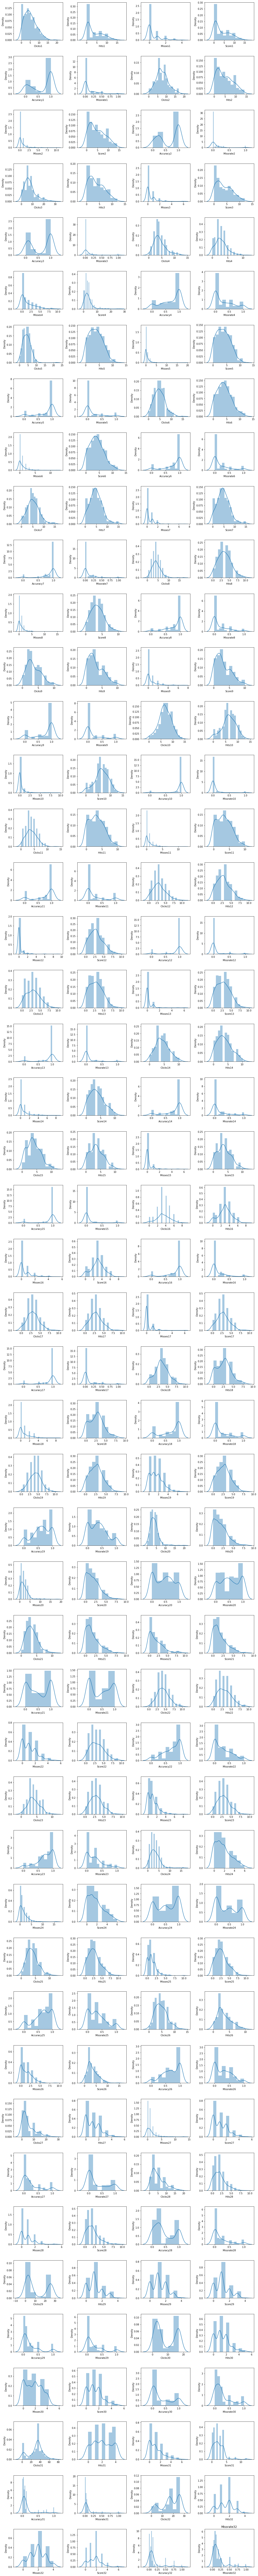

In [23]:
plot_dist(data_Q)

### Selección de características

Se eliminan aquellas filas que contienen valores anómalos de los datasets inciales, recuperando las columnas: 'Gender', 'Nativelang', 'Otherlang', 'Age', 'Dyslexia'

In [21]:
data = data.loc[data_Q.index]

Se van a definir dos funciones nuevas, `corr_hit_miss`y `corr_acc_missrate`, para comparar como de correladas están las variables *Clicks*, *Hits*, *Misses* y *Score* y la suma de las variables *Hits y Misses* con *Clicks*.

In [22]:
def corr_hit_miss(ds, nombre):
    print(nombre+" dataset")
    for i in range(32):
        try:        
            print("Question", str(i+1))
            #Pearson correlation coef
            correlation_misses = ds['Clicks'+str(i+1)].corr(ds['Misses'+str(i+1)])
            correlation_hits = ds['Clicks'+str(i+1)].corr(ds['Hits'+str(i+1)])
            correlation_score = ds['Clicks'+str(i+1)].corr(ds['Score'+str(i+1)])

            ds['Hits + Misses'+str(i+1)] = ds['Hits'+str(i+1)] + ds['Misses'+str(i+1)]
            correlation_sum = ds['Clicks'+str(i+1)].corr(ds['Hits + Misses'+str(i+1)])

            print("Misses", str(i+1), correlation_misses)
            print("Hits", str(i+1), correlation_hits)
            print("Score", str(i+1), correlation_score)
            print("Hits + Misses", str(i+1), correlation_sum)
        except KeyError:
            print("Question "+str(i+1)+" not in the dataset")
            
    print("\n")

In [23]:
def corr_acc_missrate(ds, nombre):
    print(nombre+" dataset")
    for i in  range(32):
        try:
            print("Question"+str(i+1))
            #Pearson correlation coeff
            correlation_acc = ds['Hits'+str(i+1)].corr(ds['Accuracy'+str(i+1)])
            correlation_missrate = ds['Misses'+str(i+1)].corr(ds['Missrate'+str(i+1)])
            correlation_accs_rate = ds['Accuracy'+str(i+1)].corr(ds['Missrate'+str(i+1)])

            print("Accuracy"+str(i+1),correlation_acc)
            print("Missrate"+str(i+1),correlation_missrate)
            print("Between Accuracy and Missrate"+str(i+1),correlation_accs_rate)
        except KeyError:
            print("Question "+str(i+1)+" not in the dataset")
            
    print("\n")

Se comprobará tanto para los dataset de entrenamiento, como de prueba y diferenciando entre los cuatro casos distintos tras aplicar las técnicas de gestión de outliers

In [24]:
corr_hit_miss(data, "Model")
corr_acc_missrate(data, "Model")

Model dataset
Question 1
Misses 1 0.10278111907390329
Hits 1 0.8044619984611477
Score 1 0.7961450428009983
Hits + Misses 1 0.8899906266723839
Question 2
Misses 2 0.15741833595285593
Hits 2 0.4052318710431967
Score 2 0.40734923958199926
Hits + Misses 2 0.5052606543393305
Question 3
Misses 3 0.16897937017631043
Hits 3 0.0931512688999364
Score 3 0.15410569968181606
Hits + Misses 3 0.15241883845898122
Question 4
Misses 4 0.6041495285691211
Hits 4 0.6147563100710528
Score 4 0.5990080983564494
Hits + Misses 4 1.0
Question 5
Misses 5 0.3355168971744452
Hits 5 0.7967334863080473
Score 5 0.7883299118367915
Hits + Misses 5 1.0
Question 6
Misses 6 0.039909951391479945
Hits 6 0.8851569445447114
Score 6 0.8851569445447114
Hits + Misses 6 1.0
Question 7
Misses 7 0.10761663693383464
Hits 7 0.9591488795430749
Score 7 0.9591488795430749
Hits + Misses 7 1.0
Question 8
Misses 8 0.37198758524205994
Hits 8 0.7660645637023022
Score 8 0.7562757940894878
Hits + Misses 8 0.9999999999999999
Question 9
Misses 9 

In [27]:
for i in range(32):
    columns = ['Accuracy'+str(i+1), 'Missrate'+str(i+1), 'Score'+str(i+1)]
    try:
        
        data = data.drop(columns, axis=1)
    except KeyError:
        print("Colmuns not found: ",columns)

In [28]:
data.head()

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Clicks2,Hits2,Misses2,Clicks3,Hits3,Misses3,Clicks4,Hits4,Misses4,Clicks5,Hits5,Misses5,Clicks6,Hits6,Misses6,Clicks7,Hits7,Misses7,Clicks8,Hits8,Misses8,Clicks9,Hits9,Misses9,Clicks10,Hits10,Misses10,Clicks11,Hits11,Misses11,Clicks12,Hits12,Misses12,Clicks13,Hits13,Misses13,Clicks14,Hits14,Misses14,Clicks15,Hits15,Misses15,Clicks16,Hits16,Misses16,Clicks17,Hits17,Misses17,Clicks18,Hits18,Misses18,Clicks19,Hits19,Misses19,Clicks20,Hits20,Misses20,Clicks21,Hits21,Misses21,Clicks22,Hits22,Misses22,Clicks23,Hits23,Misses23,Clicks24,Hits24,Misses24,Clicks25,Hits25,Misses25,Clicks26,Hits26,Misses26,Clicks27,Hits27,Misses27,Clicks28,Hits28,Misses28,Clicks29,Hits29,Misses29,Clicks30,Hits30,Misses30,Clicks31,Hits31,Misses31,Clicks32,Hits32,Misses32,Dyslexia,Hits + Misses1,Hits + Misses2,Hits + Misses3,Hits + Misses4,Hits + Misses5,Hits + Misses6,Hits + Misses7,Hits + Misses8,Hits + Misses9,Hits + Misses10,Hits + Misses11,Hits + Misses12,Hits + Misses13,Hits + Misses14,Hits + Misses15,Hits + Misses16,Hits + Misses17,Hits + Misses18,Hits + Misses19,Hits + Misses20,Hits + Misses21,Hits + Misses22,Hits + Misses23,Hits + Misses24,Hits + Misses25,Hits + Misses26,Hits + Misses27,Hits + Misses28,Hits + Misses29,Hits + Misses30,Hits + Misses31,Hits + Misses32
1385,1.0,0.0,1.0,7.0,6.0,6.0,0.0,6.0,6.0,0.0,4.0,4.0,0.0,7.0,0.0,7.0,5.0,5.0,0.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,6.0,5.0,1.0,2.0,2.0,0.0,3.0,3.0,0.0,2.0,2.0,0.0,3.0,3.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,4.0,0.0,4.0,1.0,0.0,1.0,2.0,1.0,1.0,4.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,3.0,2.0,1.0,9.0,2.0,0.0,3.0,1.0,0.0,10.0,0.0,3.0,10.0,0.0,1.0,32.0,0.0,1.0,21.0,1.0,1.0,0.0,6.0,6.0,4.0,7.0,5.0,3.0,3.0,0.0,2.0,6.0,2.0,3.0,2.0,3.0,2.0,2.0,1.0,0.0,4.0,4.0,1.0,2.0,4.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0
2313,0.0,1.0,1.0,12.0,3.0,1.0,0.0,9.0,0.0,3.0,18.0,2.0,1.0,10.0,4.0,6.0,3.0,1.0,2.0,6.0,6.0,0.0,6.0,6.0,0.0,6.0,6.0,0.0,5.0,5.0,0.0,6.0,6.0,0.0,4.0,3.0,1.0,5.0,5.0,0.0,1.0,1.0,0.0,4.0,0.0,4.0,5.0,5.0,0.0,4.0,2.0,2.0,5.0,5.0,0.0,4.0,4.0,0.0,5.0,3.0,2.0,8.0,6.0,2.0,5.0,1.0,4.0,5.0,4.0,1.0,3.0,3.0,0.0,5.0,2.0,3.0,9.0,7.0,2.0,2.0,2.0,0.0,5.0,0.0,5.0,5.0,2.0,3.0,26.0,0.0,4.0,5.0,3.0,2.0,31.0,1.0,2.0,16.0,0.0,3.0,0.0,1.0,3.0,3.0,10.0,3.0,6.0,6.0,6.0,5.0,6.0,4.0,5.0,1.0,4.0,5.0,4.0,5.0,4.0,5.0,8.0,5.0,5.0,3.0,5.0,9.0,2.0,5.0,5.0,4.0,5.0,3.0,3.0
1259,1.0,0.0,0.0,9.0,3.0,0.0,1.0,11.0,1.0,2.0,15.0,3.0,0.0,5.0,1.0,4.0,4.0,3.0,1.0,9.0,9.0,0.0,5.0,5.0,0.0,3.0,3.0,0.0,7.0,7.0,0.0,6.0,6.0,0.0,6.0,6.0,0.0,3.0,3.0,0.0,3.0,3.0,0.0,6.0,5.0,1.0,4.0,4.0,0.0,5.0,5.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,4.0,3.0,1.0,5.0,3.0,2.0,3.0,3.0,0.0,6.0,5.0,1.0,2.0,1.0,1.0,2.0,0.0,2.0,5.0,3.0,2.0,5.0,3.0,2.0,3.0,2.0,1.0,3.0,3.0,0.0,26.0,2.0,2.0,4.0,3.0,1.0,35.0,4.0,0.0,17.0,1.0,3.0,0.0,1.0,3.0,3.0,5.0,4.0,9.0,5.0,3.0,7.0,6.0,6.0,3.0,3.0,6.0,4.0,5.0,3.0,2.0,4.0,5.0,3.0,6.0,2.0,2.0,5.0,5.0,3.0,3.0,4.0,4.0,4.0,4.0
2158,1.0,1.0,0.0,15.0,6.0,6.0,0.0,11.0,11.0,0.0,7.0,7.0,0.0,4.0,4.0,0.0,8.0,8.0,0.0,1.0,0.0,1.0,3.0,3.0,0.0,7.0,6.0,1.0,4.0,3.0,1.0,8.0,8.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,3.0,3.0,0.0,3.0,3.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,4.0,3.0,1.0,7.0,5.0,2.0,5.0,2.0,3.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,2.0,2.0,7.0,5.0,2.0,5.0,5.0,0.0,5.0,3.0,2.0,7.0,3.0,4.0,15.0,2.0,1.0,16.0,4.0,1.0,11.0,0.0,3.0,17.0,2.0,2.0,45.0,4.0,1.0,26.0,3.0,1.0,0.0,6.0,11.0,7.0,4.0,8.0,1.0,3.0,7.0,4.0,8.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,7.0,5.0,3.0,2.0,4.0,7.0,5.0,5.0,7.0,3.0,5.0,3.0,4.0,5.0,4.0
1184,0.0,0.0,1.0,7.0,6.0,6.0,0.0,5.0,5.0,0.0,5.0,5.0,0.0,6.0,0.0,6.0,4.0,4.0,0.0,3.0,3.0,0.0,3.0,3.0,0.0,5.0,5.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,3.0,3.0,0.0,2.0,2.0,0.0,4.0,4.0,0.0,6.0,6.0,0.0,2.0,2.0,0.0,3.0,3.0,0.0,2.0,2.0,0.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,1.0,4.0,3.0,1.0,4.0,3.0,1.0,3.0,2.0,1.0,4.0,1.0,3.0,4.0,2.0,2.0,12.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,13.0,1.0,1.0,25.0,0.0,0.0,26.0,2.0,2.0,0.0,6.0,5.0,5.0,6.0,4.0,3.0,3.0,5.0,1.0,3.0,3.0,2.0,4.0,6.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0,4.0,4.0,3.0

### Divide data

Tras realizar la limpieza y preparar los datos que se van a emplear para diseñar el modelo, se va a proceder con la separación entre las variables que se van a empelar para entrenar el modelo y la variable que se quiere predecir. Es decir, se va a diferenciar entre **X**, set con todas las variables excepto si una persona es disléxica o no, e **y**, set que contiene los valores corresondientes a la variable *Dyslexia*.

In [29]:
from sklearn.model_selection import train_test_split

y = data['Dyslexia']
X = data.loc[:, data.columns != 'Dyslexia']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify = y)

# Data Standardization -> Good practice working with KNN (based on the distance)
X_train_st = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_test_st = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

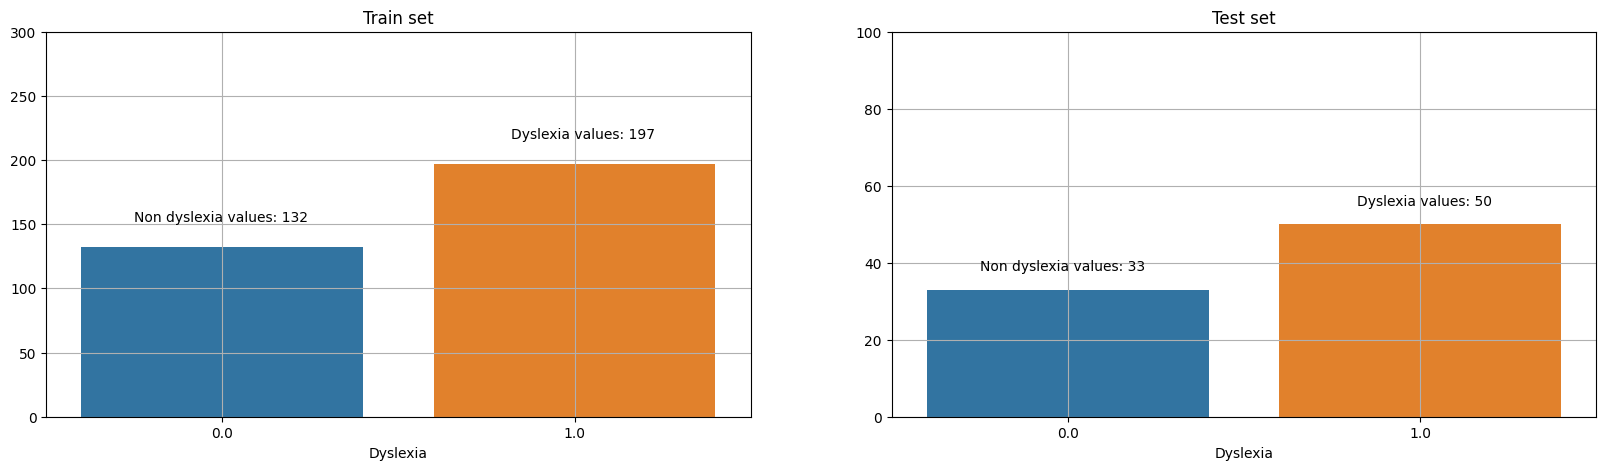

In [32]:
# Dyslexia histogram
dyslexia_train = y_train.value_counts()
dyslexia_test = y_test.value_counts()

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x=dyslexia_train.index, y=dyslexia_train.values, ax=ax[0])
ax[0].set_title('Train set')
ax[0].set_ylim([0, 300])
ax[0].grid(True)
ax[0].annotate('Non dyslexia values: ' + str(dyslexia_train[0]), xy=(1, dyslexia_train[0]), xytext=(-0.25, dyslexia_train[0] + 20))
ax[0].annotate('Dyslexia values: ' + str(dyslexia_train[1]), xy=(1, dyslexia_train[1]), xytext=(0.82, dyslexia_train[1] + 20))

sns.barplot(x=dyslexia_test.index, y=dyslexia_test.values, ax=ax[1])
ax[1].set_title('Test set')
ax[1].set_ylim([0, 100])
ax[1].grid(True)
ax[1].annotate('Non dyslexia values: ' + str(dyslexia_test[0]), xy=(1, dyslexia_test[0]), xytext=(-0.25, dyslexia_test[0] + 5))
ax[1].annotate('Dyslexia values: ' + str(dyslexia_test[1]), xy=(1, dyslexia_test[1]), xytext=(0.82, dyslexia_test[1] + 5))

plt.show()


## Modeling Training

In [33]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, jaccard_score

Se va a proceder a entrenar el modelo. Como se mencionó al inicio del documento se van a emplear cinco algoritmos distintos de Machine Learning, de los cuales se eligirá el que prediga los casos positivos y negativos.

Antes de comenzar con el entrenamiento del modelo se van a definir varias funciones con el objetivo de simplificar el código:

- `plot_confusion_matrix(cm, classes)`: toma como argumentos de entrada la matriz de confusión del modelo y los valores que se quieren evaluar, en este caso 0's y 1's. Mostrará por pantalla la representación de los aciertos y fallos comparando que casos se han predicho correctamente y cuales no.
- `knn_accuracy(X_train, y_train, X_test, y_test, Ks)`: uno de los algoritmos de Machine Learning que se va a entrenar es K-Nearest Neighbors, por lo que es necesario escoger cuidadosamente el número de clusters con el que se va a entrenar el modelo. Mediante esta función, pasando como argumentos de entrada los datos usados para el train y el test y el máximo de clusters que se quieren probar, se imprimirá por pantalla la exactitud (*accuracy*) que tiene el modelo en función de los distintos valores de k
- `k_fold_cv(X, y, n, model)`: K-fold  cross-validation se emplea como técnica de evaluación del modelo recursiva. Pasando como argumentos de entrada los datos, el modelo que se quiere testear y la cantidad de iteración que se van a realizar, la función va a dividir de diferente forma los datos n veces y calcular la media de los resultados obtenidos en cada iteración al final. Se ha especificado que devuelva la excatitud del modelo (*score*) y el F1-score de las dos clases, es decir, tanto de los 0's como de los 1's
- `evaluate_model(X_train, y_train, X_test, y_test, model)`: esta función va a devolver distintas evaluaciones del modelo, como por ejemplo *Recall*, *Accuracy*, *Jaccard index* o *F1-score*, así como la representación de la matriz de confusión del modelo que se especifique.

In [34]:
import itertools

def plot_confusion_matrix(cm, classes):
    # Create figure and axes
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    #add value count to each cell
    fmt = 'd'
    thresh = cm.max() / 3.
    
    #labels value count
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #set axis labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    #colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    plt.show()

In [35]:
#calculate nº clusters KNN
def knn_accuracy(X_train, y_train, X_test, y_test, Ks):
    
    for n in range(1,Ks):
        model = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
        y_hat = model.predict(X_test)
        
        acc = metrics.accuracy_score(y_test, y_hat)
        print(f"Value of k: {n} - Accuracy: {acc:.2f}")

In [36]:
def k_fold_cv(X, y, n, model):
    kf = KFold(n_splits = n)
    
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    
    #accuracy
    scores = []
    #f1 score
    f1_score_0 = []
    f1_score_1 = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
        y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
        #model prediction 
        y_hat = model.predict(X_test)
        #evaluate the performance of a model (accuracy score)
        score = model.score(X_test,y_test)
        scores.append(score)
        #accuracy of a binary classification model
        f1_0 = f1_score(y_test, y_hat, pos_label=0)
        f1_1 = f1_score(y_test, y_hat, pos_label=1)
        f1_score_0.append(f1_0)
        f1_score_1.append(f1_1)
        
    
    return "Accuracy: "+str(np.mean(scores)), "F1-score 0's: "+str(np.mean(f1_score_0)), "F1-score 1's: "+str(np.mean(f1_score_1))

In [37]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
    
    y_hat = model.predict(X_test)
    
    #different evaluations
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, model.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_hat))
    print("F1 score: ", f1_score(y_test, y_hat))
    print("Recall 0's: ", recall_score(y_test, y_hat, pos_label=0))
    print("Recall 1's: ", recall_score(y_test, y_hat, pos_label=1))
    print("Jaccard index 0's: ", jaccard_score(y_test, y_hat, pos_label = 0))
    print("Jaccard index 1's: ", jaccard_score(y_test, y_hat, pos_label = 1))
    print("\n")
    
    #classification report
    print (classification_report(y_test, y_hat))
    print("\n")

    #compute confusion matrix
    cm = confusion_matrix(y_test, y_hat, labels=[0,1])
    np.set_printoptions(precision = 2)

    #plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=['No = 0','Yes = 1'])

## 1. K-Nearest Neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
knn_accuracy(X_train_st, y_train, X_test_st, y_test, 10)

Value of k: 1 - Accuracy: 0.70
Value of k: 2 - Accuracy: 0.69
Value of k: 3 - Accuracy: 0.69
Value of k: 4 - Accuracy: 0.67
Value of k: 5 - Accuracy: 0.70
Value of k: 6 - Accuracy: 0.72
Value of k: 7 - Accuracy: 0.71
Value of k: 8 - Accuracy: 0.76
Value of k: 9 - Accuracy: 0.73


In [40]:
k = 3
#Train Model and Predict  
neighbor = KNeighborsClassifier(n_neighbors = k).fit(X_train_st,y_train)
y_hat_KNN = neighbor.predict(X_test_st)

In [41]:
k_fold_cv(X, y, 10, neighbor)

('Accuracy: 0.5564459930313589',
 "F1-score 0's: 0.3849643874643875",
 "F1-score 1's: 0.27897081998698453")

Train set Accuracy:  0.878419452887538
Test set Accuracy:  0.6867469879518072
F1 score:  0.7547169811320756
Recall 0's:  0.5151515151515151
Recall 1's:  0.8
Jaccard index 0's:  0.3953488372093023
Jaccard index 1's:  0.6060606060606061


              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57        33
         1.0       0.71      0.80      0.75        50

    accuracy                           0.69        83
   macro avg       0.67      0.66      0.66        83
weighted avg       0.68      0.69      0.68        83





<Figure size 640x480 with 0 Axes>

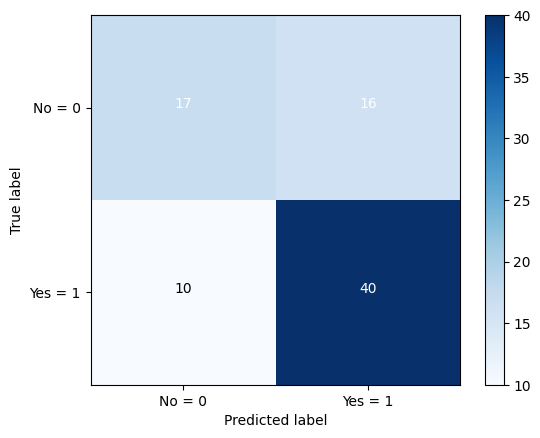

In [42]:
evaluate_model(X_train_st, y_train, X_test_st, y_test, neighbor)

## 2. Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
# Train Model and Predict  
mod_LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_st,y_train)
y_hat_LR = mod_LR.predict(X_test_st)

# Predict the probability of each class for a given input
y_hat_prob = mod_LR.predict_proba(X_test_st)

In [45]:
k_fold_cv(X, y, 10, mod_LR)

('Accuracy: 0.5',
 "F1-score 0's: 0.39753086419753086",
 "F1-score 1's: 0.1377450980392157")

Train set Accuracy:  0.8571428571428571
Test set Accuracy:  0.7951807228915663
F1 score:  0.8247422680412372
Recall 0's:  0.7878787878787878
Recall 1's:  0.8
Jaccard index 0's:  0.6046511627906976
Jaccard index 1's:  0.7017543859649122


              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75        33
         1.0       0.85      0.80      0.82        50

    accuracy                           0.80        83
   macro avg       0.79      0.79      0.79        83
weighted avg       0.80      0.80      0.80        83





<Figure size 640x480 with 0 Axes>

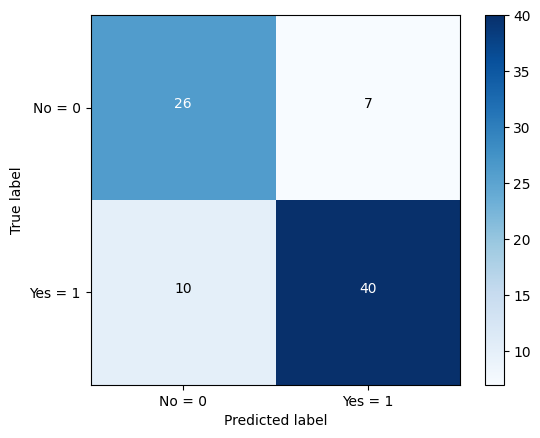

In [46]:
evaluate_model(X_train_st, y_train, X_test_st, y_test, mod_LR)

## 3. Support Vector Machines

In [47]:
from sklearn import svm

In [55]:
# Model: svm.SVC(kernel='rbf')
# kernel='rbf'" where 'rbf' stands for radial basis function

In [48]:
# Train Model and Predict 
mod_SVM = svm.SVC(kernel='poly', degree=15, coef0=7).fit(X_train, y_train) 
y_hat_SVM = mod_SVM.predict(X_test)

In [49]:
k_fold_cv(X, y, 10, mod_SVM)

('Accuracy: 0.9491869918699187',
 "F1-score 0's: 0.38493472537776335",
 "F1-score 1's: 0.6387333958431005")

Train set Accuracy:  1.0
Test set Accuracy:  0.7469879518072289
F1 score:  0.796116504854369
Recall 0's:  0.6363636363636364
Recall 1's:  0.82
Jaccard index 0's:  0.5
Jaccard index 1's:  0.6612903225806451


              precision    recall  f1-score   support

         0.0       0.70      0.64      0.67        33
         1.0       0.77      0.82      0.80        50

    accuracy                           0.75        83
   macro avg       0.74      0.73      0.73        83
weighted avg       0.74      0.75      0.74        83





<Figure size 640x480 with 0 Axes>

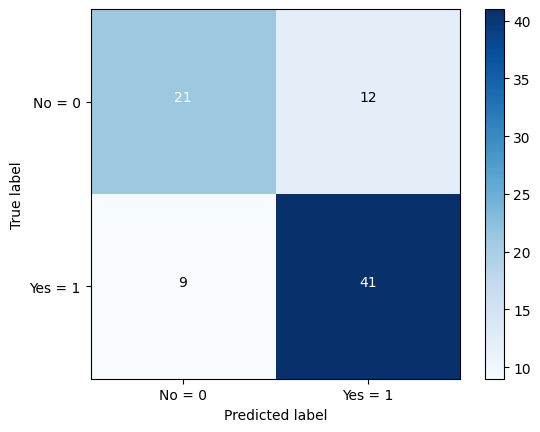

In [50]:
evaluate_model(X_train, y_train, X_test, y_test, mod_SVM)

# 4. Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Train Model and Predict 
mod_rfc = RandomForestClassifier(n_estimators = 6, max_depth = 5, min_samples_leaf = 5).fit(X_train , y_train)
y_hat_RF = mod_rfc.predict(X_test)

In [53]:
k_fold_cv(X, y, 10, mod_rfc)

('Accuracy: 0.8450058072009291',
 "F1-score 0's: 0.33422073783190986",
 "F1-score 1's: 0.5923335298862725")

Train set Accuracy:  0.8571428571428571
Test set Accuracy:  0.7951807228915663
F1 score:  0.8440366972477064
Recall 0's:  0.6060606060606061
Recall 1's:  0.92
Jaccard index 0's:  0.5405405405405406
Jaccard index 1's:  0.7301587301587301


              precision    recall  f1-score   support

         0.0       0.83      0.61      0.70        33
         1.0       0.78      0.92      0.84        50

    accuracy                           0.80        83
   macro avg       0.81      0.76      0.77        83
weighted avg       0.80      0.80      0.79        83





<Figure size 640x480 with 0 Axes>

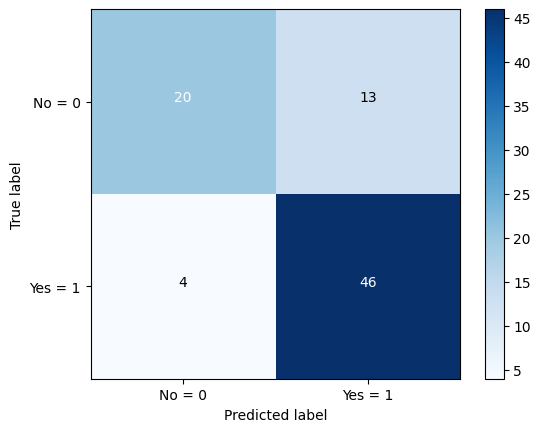

In [54]:
evaluate_model(X_train, y_train, X_test, y_test, mod_rfc)

## 5. Tree Decision

In [55]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

In [56]:
# Train Model and Predict 
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 4).fit(X_train, y_train)
y_hat_tree = tree.predict(X_test)

In [57]:
k_fold_cv(X, y, 10, tree)

('Accuracy: 0.8470383275261323',
 "F1-score 0's: 0.35975368590522805",
 "F1-score 1's: 0.5560579844119813")

Train set Accuracy:  0.8632218844984803
Test set Accuracy:  0.7831325301204819
F1 score:  0.8235294117647058
Recall 0's:  0.696969696969697
Recall 1's:  0.84
Jaccard index 0's:  0.5609756097560976
Jaccard index 1's:  0.7


              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72        33
         1.0       0.81      0.84      0.82        50

    accuracy                           0.78        83
   macro avg       0.77      0.77      0.77        83
weighted avg       0.78      0.78      0.78        83





<Figure size 640x480 with 0 Axes>

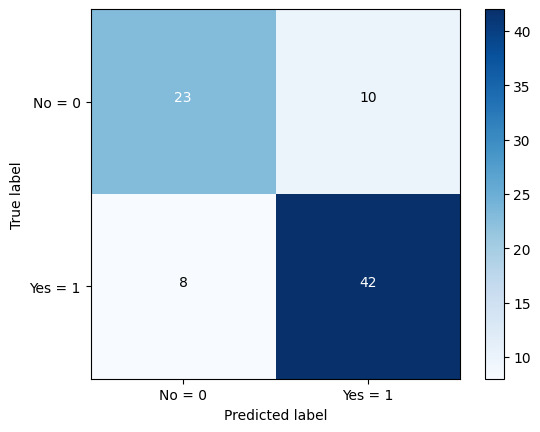

In [58]:
evaluate_model(X_train, y_train, X_test, y_test, tree)

Se puede observar como los resultados obtenidos dejan mucho que desear. Esto se debe a que al reducir los datos al número de casos positivos de disexia con los que contaba el dataset, no se tienen suficientes datos como para entrenar correctamente el modelo.